# Electron Shuttling

This tutorial will show how to simulate electron shuttling using QuDiPy.  We will show you can build an example shuttling pulse and subsequently simulate electron shuttling through a triple quantum dot chain.

## 1. Load relevant modules and add the current location to path

In [4]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import qudipy as qd
import numpy as np
import qudipy.potential as pot
import qudipy.shuttling as shut

## 2. Load potential files

We need to first construct a `PotentialInterpolator` object from some pre-processed potential files (i.e. potentials that have already been exported fron nextnano into a csv file containing a 2D potential slice). The potentials we are loading correspond to a 5-quantum dot linear chain system where each dot in the chain is formed by a single plunger gate labelled *V#*. The gap between plunger gates forms a tunnel barrier between neighboring quantum dots. For our simulations, the outer-most plunger gate voltages remain fixed, and we will only shuttle an electron through the middle three dots using plunger gates *V2*, *V3*, and *V4*.

Please refer to the Loading Potentials tutorial for more information on loading potentials.

In [8]:
# Load preprocessed potential files from the potentail folder
pot_dir = os.path.dirname(os.getcwd()) + '/tutorials/QuDiPy tutorial data/Pre-processed potentials/'
    
# Specify the control voltage names (C#NAME as mentioned above)
ctrl_names = ['V1','V2','V3','V4','V5']

# Specify the control voltage values you wish to load.
# The cartesian product of all these supplied voltages will be loaded and MUST exist in the directory.
V1 = [0.1]
V2 = [0.2, 0.22, 0.24, 0.26, 0.27, 0.28]
V3 = [0.2, 0.22, 0.24, 0.26, 0.27, 0.28]
V4 = [0.2, 0.22, 0.24, 0.26, 0.27, 0.28]
V5 = [0.1]
# Add all voltage values to a list
ctrl_vals = [V1, V2, V3, V4, V5]    

# Now load the potentials.  
# load_files returns a dictionary of all the information loaded
loaded_data = pot.load_potentials(ctrl_vals, ctrl_names, f_type='pot', 
                                  f_dir=pot_dir, f_pot_units="eV", 
                                  f_dis_units="nm")

# Now building the interpolator object is trivial
# Note the use of y-slice here which builds a 1D potential 
# interpolator at y=0 for all potentials.
pot_interp = pot.build_interpolator(loaded_data, 
                                    constants=qd.Constants("Si/SiO2"),
                                    y_slice=0)

## 3. Building the shuttling control pulse

Now, we need to actually construct a control pulse to shuttle an electron across our triple quantum dot chain. We will initialize the electron in the left-most dot underneath *V2* and subsequently shuttle the electron to be underneath *V3* and finally *V4*. For simplicity, we will only vary a single plunger gate voltage at a time.

To start then, we will define the initial voltage configuration of the pulse.

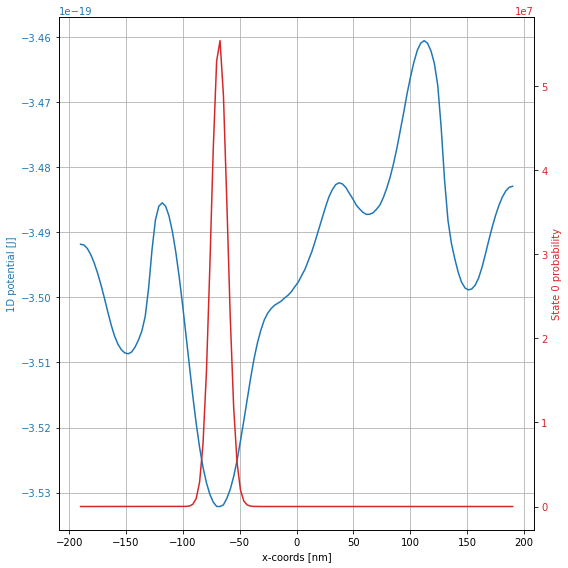

In [9]:
# Define some min and max voltage values
min_v = 0.2
max_v = 0.278

# Specify the first point.
pt1 = [max_v, min_v, min_v]
pot_interp.plot(pt1, show_wf=True)

We can see that at the start of the pulse the electron is localized in the 2nd quantum dot in the chain, underneath *V2*. The next step in constructing the pulse is to sweep *V3* to the resonant tunnel coupling point between dots 2 and 3. This can be done using the `.find_resonant_tc()` method of the `potentialInterpolator` object `pot_interp`. This method varies a specified control variable (in this case, we will vary *V3*) until it finds the point where the electron wavefunciton is equally localized between the two dots.

In order to remain adiabatic (in the ground state) as we apply our control pulse, *V3* must be swept slowly enough as to not excite out simulated wavefunction into higher orbital states. Near the resonant tunnel coupling point, this is a greater concerned as the energy spectra of the system Hamiltonian at that time is the smallest.  However, further away from the resonant tunnel coupling point, we can sweep *V3* much faster. So we will slightly 'shape' our pulse a bit by quickly ramping *V3* until we get close to the resonant tunnel coupling point at which we will sweep slower.

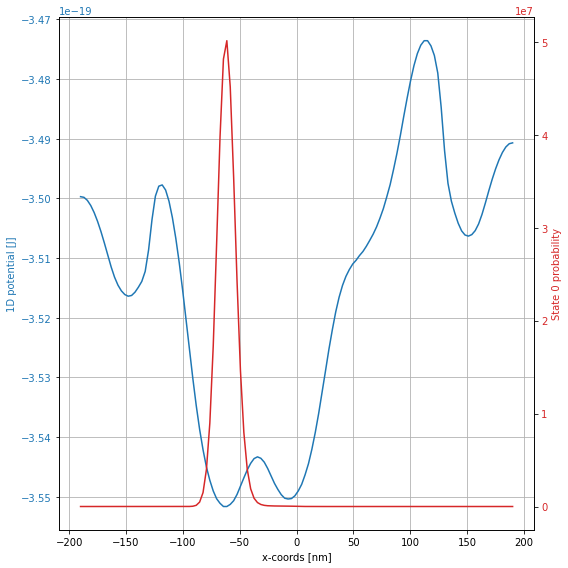

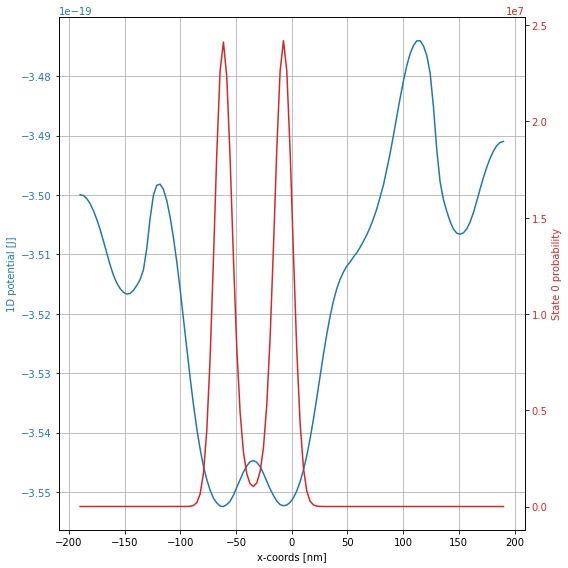

In [11]:
# First use find_resonant_tc to find the resonant tunnel coupling point.
# We pass in a voltage vector specifying the voltage values for the
# rest of the control variables and then specify which control variable
# we wish to vary when searching for a resonant tunnel coupling point.
res_vv = pot_interp.find_resonant_tc(pt1, 'V3')

# Find the voltage configuration close to the resonant tunnel coupling point.
almost_res_vv = res_vv - 0.035 * (max_v - min_v)
pt2 = pt1.copy()
pt2[1] = almost_res_vv
pot_interp.plot(pt2, show_wf=True)

# Find the voltage configuration right at the resonant tunnel coupling point
pt3 = pt2.copy()
pt3[1] = res_vv
pot_interp.plot(pt3, show_wf=True)

Now we can start to get a better feel for how the electron should evolve according to the pulse. Notice that at the second voltage configuration `pt2`, there is a very very small hump starting to form underneath *V3* indicating we are nearing the resonant tunnel coupling point. At the resonant tunnel coupling point `pt3`, the electron is equally split between the second and third dots in the chain. 

From here, we will repeat the same procedure, but in reverse with *V1* in order to fully localize the electron underneath *V3*.

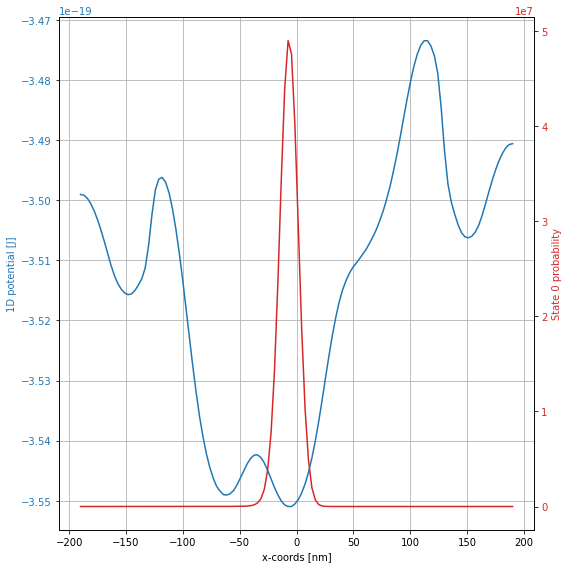

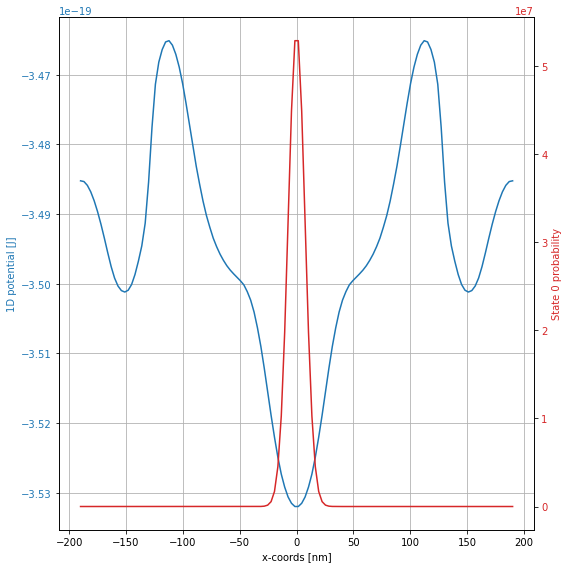

In [12]:
# Sweep V1 to the close to resonant tunnel coupling voltage configuration
pt4 = pt3.copy()
pt4[0] = almost_res_vv
pot_interp.plot(pt4, show_wf=True)

# Sweep V1 to the minimum voltage to full localize the dot underneath V3.
pt5 = pt4.copy()
pt5[0] = min_v
pot_interp.plot(pt5, show_wf=True)

Now that we have done one dot-to-dot transfer the next one follows the same procedure. We will omit plotting the wavefunciton at each voltage configuration not except for the final one.

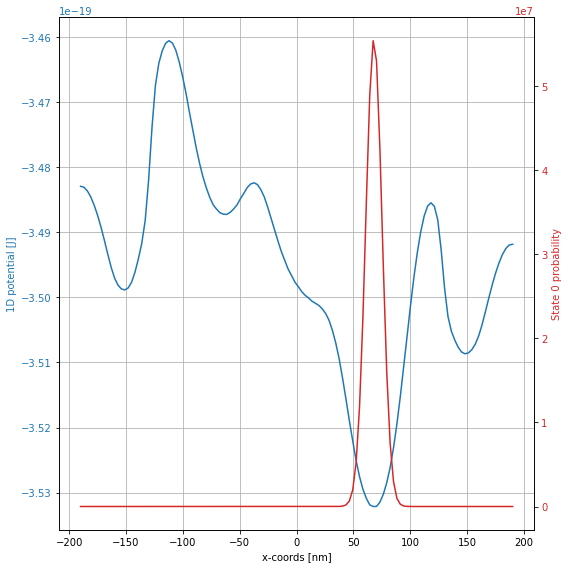

In [14]:
# Find resonant tunnel coupling point w.r.t. V4
res_vv = pot_interp.find_resonant_tc(pt5, 'V4')

# Sweep V4 to almost the resonant tunnel coupling point
almost_res_vv = res_vv - 0.035 * (max_v - min_v)
pt6 = pt5.copy()
pt6[2] = almost_res_vv

# Sweep V4 to the resonant tunnel coupling point
pt7 = pt6.copy()
pt7[2] = res_vv

# Sweep V3 to almost the resonant tunnel coupling point
pt8 = pt7.copy()
pt8[1] = almost_res_vv

# Sweep V3 to the minimum voltage and fully localize
# the electron underneath V4
pt9 = pt8.copy()
pt9[1] = min_v
pot_interp.plot(pt9, show_wf=True)

Now we have 9 voltage configurations that roughly outline our control pulse. However, the next step of the process is to actuall build a `ControlPulse` object with these voltage configurations. To do so, we will first compile all of the configurations into a single 2D array and also construct a time array to indicate at what time point each voltage configuration should occur.

In [15]:
# Assemble all the voltage configurations into a 2D array
shuttle_pulse = np.array([pt1, pt2, pt3, pt4, pt5, pt6, pt7, pt8, pt9])

# Specify the total overall length of the control pulse in seconds
pulse_length = 10E-12 # 10 ps
# Initialize a ControlPulse with name 'shuttle_exp' and 
# 'experimental' control variables.
shut_pulse = qd.circuit.ControlPulse('shuttle_exp', 'experimental', 
                                    pulse_length=pulse_length)

# Add each voltage control variable now to the ControlPulse object
shut_pulse.add_control_variable('V2',shuttle_pulse[:,0])
shut_pulse.add_control_variable('V3',shuttle_pulse[:,1])
shut_pulse.add_control_variable('V4',shuttle_pulse[:,2])
# Specify a time array to correspond to each voltage configuration in the pulse
ctrl_time = pulse_length*np.array([0, 1/20, 1/4, 1/2-1/20, 1/2, 1/2+1/20, 3/4, 19/20, 1])
shut_pulse.add_control_variable('Time',ctrl_time)

You can visualize the shuttling control pulse using `ControlPulse`'s `.plot()` method.

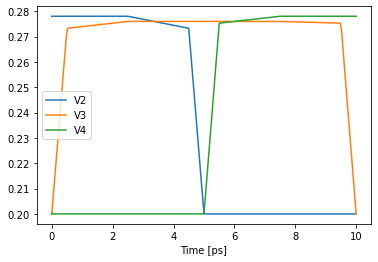

In [16]:
shut_pulse.plot()

You can see how we quickly sweep the voltages when we are far away from the resonant tunnel coupling points where we can do so without affecting the adiabaticity of the shuttling process.

Before moving along to the next step which involves us actually simulating using this pulse, you can easily change the length of the control pulse by using the `set_pulse_length` method of `ControlPulse`.

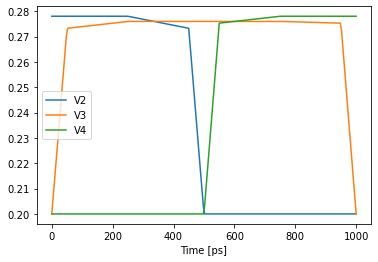

In [17]:
# Change total pulse length to 1 ns
shut_pulse.set_pulse_length(1E-9)
shut_pulse.plot()

# Change it back to 10 ps for our first actual simulation
shut_pulse.set_pulse_length(10E-12)

## 4. Evolving over time

We will now go ahead and do a simulation using the shuttling pulse. The shuttling module has the `RSP_time_evolution_1D` method which is real space (RSP) time evolution of a 1D coordinate system. It uses the split-operator method to calculate the evolution. The default time step for each simulation frame is $5*10^{-16}$ seconds.

Using the `show_animation` keyword argument, we can visualize the wave function evolution during the simulation. In addition, by specifying the `save_data` keyword argument, you can save the adiabaticity data of the evolution for later analysis in a .csv file. 

Note: the animation cannot be shown in jupyter notebook. It has to be run as a python file.

<IPython.core.display.Javascript object>


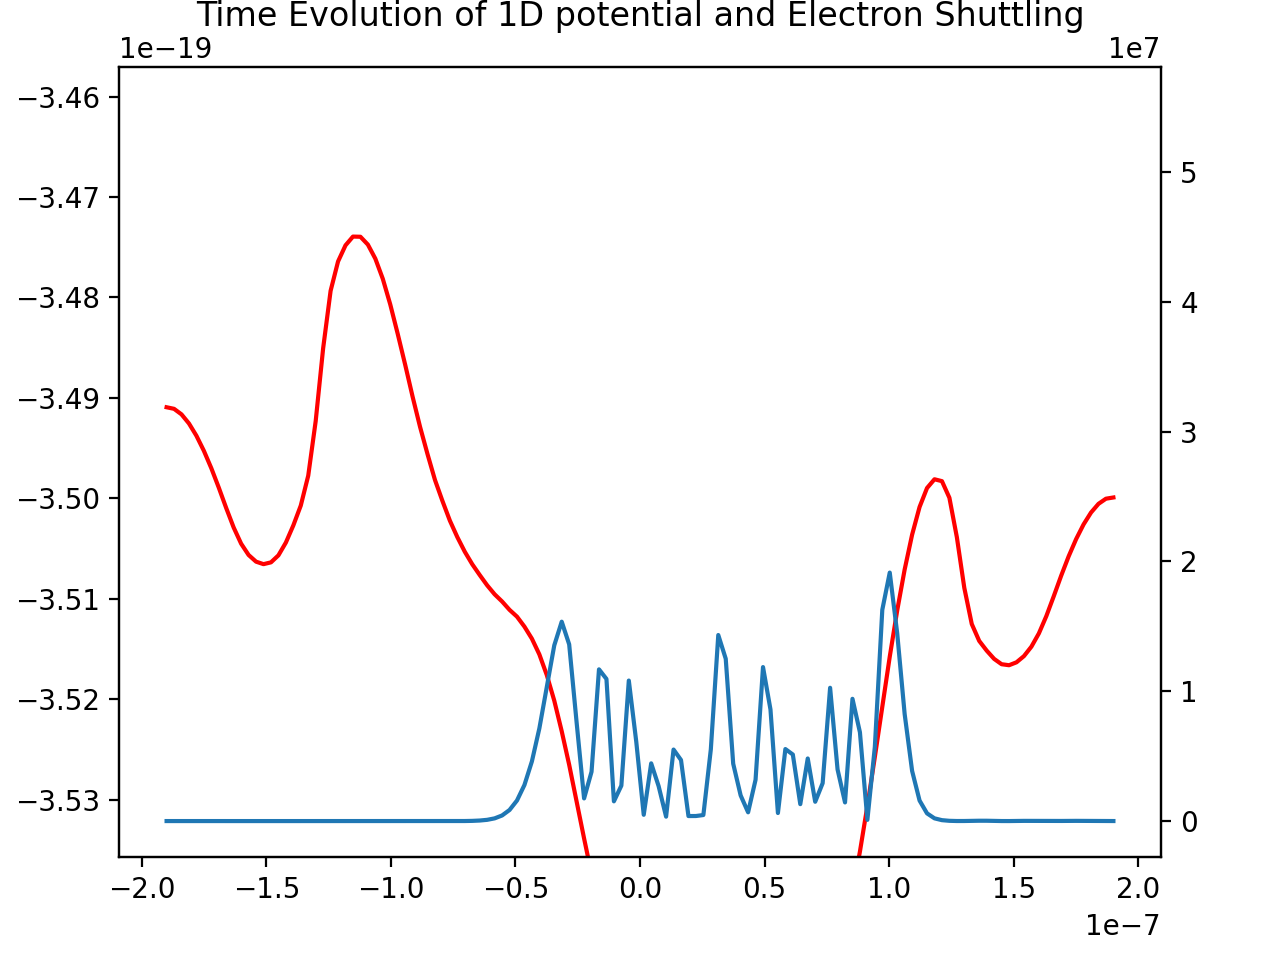

/Users/simba/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Simulation complete. Elapsed time is  5.640596625999933


In [23]:
%matplotlib notebook
shut.RSP_time_evolution_1D(pot_interp, shut_pulse, show_animation=True, save_data=True)

## 5. Plotting adiabaticity

We can plot adiabaticity of pulses with different pulse lengths on the same plot. Note that the x-axis is nondimensionalized. It represents fraction of the total pulse length rather than the actual time.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("adiabaticity.csv") 

for pulse_length in [10, 40, 200, 450]:
    time_orig = list(df[df['pulse_length'] == pulse_length]['time'])
    time = [t/pulse_length for t in time_orig]
    adiabaticity = list(df[df['pulse_length'] == pulse_length]['adiabaticity'])
    plt.plot(time,adiabaticity, label = '{} ps'.format(pulse_length))

plt.xlabel('t/pulse_length')
plt.ylabel('adiabaticity')
plt.legend()
plt.show()